# Notebook do jednowymiarowej symulacji FDTD

Importowanie bibliotek

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

from matplotlib import animation, rc
from IPython.display import HTML


import numpy as np
from numba import jit
import time

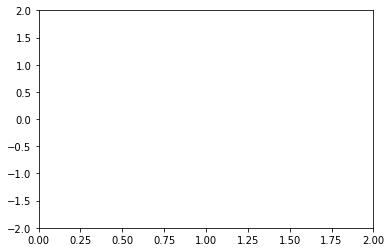

In [9]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

Funkcje pomocnicze

In [10]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)
HTML(anim.to_html5_video())

In [2]:
def load_data(nx:int, file:str = None):
    if file is None:
        return np.ones(nx)
    with open(file, 'r') as f:
        data = map(float, f.readline().split(','))
        return np.array(data)
    
def load_current(file:str = None):
    data = dict()
    if file is not None:
        with open(file, 'r') as f:
            for line in f.readlines():
                record = line.split(',')
                data[int(record[0])] = data.get(int(record[0]), []) + [(int(record[1]),float(record[2]))]
            
    data[3] = [(1,30)]
    data[4] = [(1,30)]
    data[5] = [(1,30)]
    data[6] = [(1,30)]
    data[7] = [(1,30)]
    return data


def load_source(file:str = None):
    data = dict()
    if file is not None:
        with open(file, 'r') as f:
            for line in f.readlines():
                record = line.split(',')
                data[int(record[0])] = data.get(int(record[0]), []) + [(int(record[1]),float(record[2]))]
    
    return data


In [3]:
#@jit(nopython=True)
def e_interior_update(hy, ez, nx, coef_e_loss, coef_e_step):
    for i in range(1,nx-1):
        ez[i] = coef_e_loss[i]*ez[i] + coef_e_step[i]*(hy[i]-hy[i-1])
        
#@jit(nopython=True)
def h_interior_update(hy, ez, nx, coef_h_step):
    for i in range(1,nx-1):
        hy[i] = hy[i] + coef_h_step[i]*(ez[i]-ez[i-1])
        
#@jit(nopython=True)
def e_current_apply(ez, coeff, j):
    for jt in j:
        ez[jt[0]] = ez[jt[0]] - coeff[jt[0]] * jt[1]
        
def e_boundary_conditions(ez):
    ez[0] = ez[-1]
    
def h_boundary_conditions(hy):
    hy[0] = hy[-1]
    
def e_source(ez, source):
    pass

Definiiujemy parametry siatki

In [4]:
nx = 100000
l = 0.1 # m
dx = l/nx
dx

1e-06

Alokacja siatki na $E_z$ oraz $H_y$ oraz ładowanie przenikalności $\epsilon$, $\mu$ oraz przewodniości $\sigma$ z plików. 

In [55]:
ez = np.zeros(nx)
hy = np.zeros(nx)
epsilon0 = 1
epsilon = epsilon0 * load_data(nx)
mi0 = 1
mi = mi0 * load_data(nx)
sigma = 10**(-3) * load_data(nx)
source = load_source()
j = load_current()

In [56]:
nt = 1000
dt = 0.01

Sprawdzamy warunek zbieżności

In [57]:
dx/dt<1/(epsilon0*mi0)**0.5

True

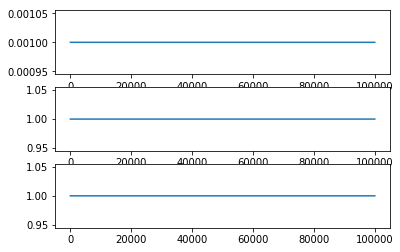

In [58]:
x = np.linspace(0, nx, nx)
fig, ax = plt.subplots(3) # create a plot figure

ax[0].plot(x, sigma)
ax[1].plot(x, mi);
ax[2].plot(x, epsilon);

Zmienne pomocnicze do pętli

In [59]:
coef_e_loss =[ (1 + sigma[i]*dt/(2*epsilon[i]))/(1 + sigma[i]*dt/(2*epsilon[i])) for i in range(nx) ]
coef_e_step =[ (dt/(dx*epsilon[i]))/(1 + sigma[i]*dt/(2*epsilon[i])) for i in range(nx) ]
coef_h_step =[ dt/(dx*mi[i]) for i in range(nx) ]
coef_j = dt/epsilon

In [60]:
save_path = "./outdata/out"
start_time = time.process_time()

for t in range(nt):
    e_interior_update(hy=hy, ez=ez, nx=nx, coef_e_loss=coef_e_loss, coef_e_step=coef_e_step)
    e_current_apply(ez=ez, coeff=coef_j, j=j.get(t,[]))
    e_boundary_conditions(ez=ez)
    e_source(ez=ez, source=source.get(t,[]))
    h_interior_update(hy=hy, ez=ez, nx=nx, coef_h_step=coef_h_step)
    h_boundary_conditions(hy=hy)
    np.save(save_path + 'hy' + str(t) + '.npy', hy)
    
end_time = time.process_time() 
print('Simulation time:', end_time - start_time, 'seconds')

Simulation time: 171.4375 seconds



[MoviePy] Building file sinc_mpl.gif with imageio




  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

  7%|██████                                                                             | 3/41 [00:00<00:01, 20.00it/s]

 15%|████████████▏                                                                      | 6/41 [00:00<00:01, 20.48it/s]

 20%|████████████████▏                                                                  | 8/41 [00:00<00:01, 19.72it/s]

 27%|██████████████████████                                                            | 11/41 [00:00<00:01, 20.18it/s]

 34%|████████████████████████████                                                      | 14/41 [00:00<00:01, 20.51it/s]

 41%|██████████████████████████████████                                                | 17/41 [00:00<00:01, 19.49it/s]

 46%|██████████████████████████████████████                                            | 19/41 [00:00<00:01, 18.29it/s]

 54%|█████████████████████████

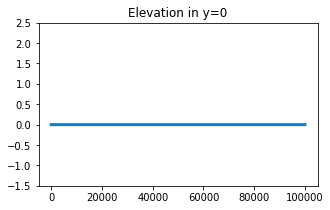

In [61]:
# DRAW A FIGURE WITH MATPLOTLIB

duration = 2

fig_mpl, ax = plt.subplots(1,figsize=(5,3), facecolor='white')
#xx = np.linspace(-2,2,200) # the x vector
#zz = lambda d: np.sinc(xx**2)+np.sin(xx+d) # the (changing) z vector
ax.set_title("Elevation in y=0")
ax.set_ylim(-1.5,2.5)
line, = ax.plot(x, np.zeros(nx), lw=3)

# ANIMATE WITH MOVIEPY (UPDATE THE CURVE FOR EACH t). MAKE A GIF.

def make_frame_mpl(t):
    data = np.load(save_path + 'hy' + str(int(t)) + '.npy')
    line.set_ydata(data)  # <= Update the curve
    return mplfig_to_npimage(fig_mpl) # RGB image of the figure

animation =mpy.VideoClip(make_frame_mpl, duration=duration)
animation.write_gif("sinc_mpl.gif", fps=20)